In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.segmentation import fcn_resnet50
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [74]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [75]:
# Define the colorization model
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.upsample(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.upsample(x)
        x = nn.functional.relu(self.conv5(x))
        x = torch.tanh(self.conv6(x))  # Output in range [-1, 1]
        return x


In [76]:
import torch
import torch.nn.functional as F

class SemanticColorizationModel(nn.Module):
    def __init__(self):
        super(SemanticColorizationModel, self).__init__()
        self.segmentation_model = fcn_resnet50(pretrained=True)
        self.colorization_model = ColorizationNet()

    def forward(self, x, mask=None):
        # Semantic segmentation
        seg_output = self.segmentation_model(x)['out']
        seg_mask = torch.argmax(seg_output, dim=1, keepdim=True)

        # Apply user-defined mask if provided
        if mask is not None:
            seg_mask = seg_mask * mask

        # Convert input to grayscale
        gray_input = torch.mean(x, dim=1, keepdim=True)

        # Colorization
        color_output = self.colorization_model(gray_input)

        # Resize color_output to match gray_input size
        color_output_resized = F.interpolate(color_output, size=gray_input.shape[2:], mode='bilinear', align_corners=False)

        # Combine original grayscale with colorized output
        combined_output = torch.cat([gray_input, color_output_resized], dim=1)

        # Apply segmentation mask
        masked_output = combined_output * seg_mask

        return masked_output, seg_mask


In [77]:
# Load and preprocess data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [78]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [79]:
# Initialize the model, loss function, and optimizer
model = SemanticColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Convert RGB image to grayscale
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# Load the model
model = torch.load('/content/drive/My Drive/Colab Notebooks/colorization_model.pth', map_location=torch.device('cpu'))


In [82]:

import torch

# Assuming state_dict is loaded from a file
state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/colorization_model.pth', map_location=torch.device('cpu'))

# Initialize your model
model = SemanticColorizationModel()

# Load state dict with strict=False to ignore non-matching keys
model.load_state_dict(state_dict, strict=False)

# Now you can use the model
model.eval()


SemanticColorizationModel(
  (segmentation_model): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

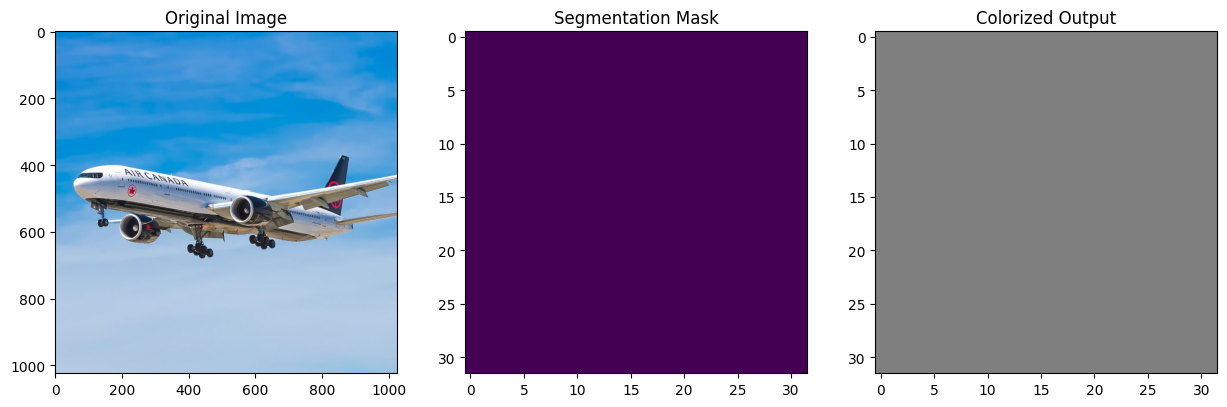

In [83]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Assuming the model and ColorizationNet classes are defined earlier in the code

# Resize transform to reduce the image size
resize_transform = transforms.Resize((32, 32))  # Resize to 32x32
transform = transforms.Compose([
    resize_transform,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Evaluation and visualization
with torch.no_grad():
    # Load a test image and resize it
    test_image = Image.open('/content/drive/My Drive/dataset-card-3.jpg').convert('RGB')
    test_input = transform(test_image).unsqueeze(0).to(device)

    # Create a smaller sample mask to match the resized image
    mask = torch.zeros((1, 1, 32, 32), device=device)  # Adjust to match the resized image dimensions
    mask[:, :, 10:20, 10:20] = 1  # Colorize a 10x10 square in the center

    # Generate output
    output, seg_mask = model(test_input, mask)

    # Convert output to image
    output_image = output.cpu().squeeze().permute(1, 2, 0).numpy()
    output_image = (output_image * 0.5 + 0.5).clip(0, 1)

    # Visualize results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(test_image)
    ax1.set_title('Original Image')
    ax2.imshow(seg_mask.cpu().squeeze(), cmap='viridis')
    ax2.set_title('Segmentation Mask')
    ax3.imshow(output_image)
    ax3.set_title('Colorized Output')
    plt.show()


In [85]:
# Calculate and print evaluation metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# You would typically have ground truth labels for your test set
# For this example, we'll use placeholder values
y_true = np.random.randint(0, 2, size=(32*32,))
y_pred = seg_mask.cpu().numpy().flatten()

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Confusion Matrix:")
print(cm)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Confusion Matrix:
[[514   0]
 [510   0]]
Precision: 0.2520
Recall: 0.5020


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
